# LEZIONE 16 - Feature Importance: MDI, Permutation e SHAP

## Obiettivi della Lezione

Al termine di questa lezione sarai in grado di:

1. **Capire** cos'e la Feature Importance e perche e fondamentale
2. **Usare** MDI (Mean Decrease Impurity) - importanza built-in degli alberi
3. **Applicare** Permutation Importance - metodo model-agnostic
4. **Comprendere** SHAP Values per spiegabilita avanzata
5. **Selezionare** features basandosi sull'importanza

## Prerequisiti

| Concetto | Dove lo trovi |
|----------|---------------|
| Random Forest | Lezione 14 |
| XGBoost/LightGBM | Lezione 15 |
| Train/Test Split | Lezione 10 |

## Indice

1. SEZIONE 1 - Teoria
2. SEZIONE 2 - Mappa Mentale
3. SEZIONE 3 - Quaderno Dimostrativo
4. SEZIONE 4 - Metodi Principali
5. SEZIONE 5 - Glossario
6. SEZIONE 6 - Errori Comuni
7. SEZIONE 7 - Conclusione
8. SEZIONE 8 - Checklist
9. SEZIONE 9 - Changelog

---

## Librerie Utilizzate

```python
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap  # opzionale
import matplotlib.pyplot as plt
```

---

## SEZIONE 1 - Teoria

### 1.1 Perche Feature Importance?

| Motivo | Descrizione |
|--------|-------------|
| **Interpretabilita** | Spiegare PERCHE il modello fa certe predizioni |
| **Feature Selection** | Eliminare features inutili o ridondanti |
| **Debug del Modello** | Verificare che usi features sensate, identificare data leakage |
| **Domain Knowledge** | Scoprire insights sui dati, validare ipotesi di business |

---

### 1.2 I Tre Metodi Principali

| Metodo | Come Funziona | Pro | Contro |
|--------|---------------|-----|--------|
| **MDI** | Misura quanto ogni feature riduce l'impurita | Velocissimo (built-in) | Bias verso alta cardinalita |
| **Permutation** | Mischia una feature e misura il peggioramento | Model-agnostic, affidabile | Piu lento |
| **SHAP** | Teoria dei giochi, contributo marginale | Spiega ogni predizione | Computazionalmente costoso |

---

### 1.3 MDI - Mean Decrease Impurity

```
Per ogni nodo dell'albero che usa feature X:
   Importance(X) += (n_samples * impurity_decrease)

Poi viene normalizzato e mediato su tutti gli alberi.
```

**Attributo**: `model.feature_importances_`

**Problema MDI**: Features con molti valori unici (alta cardinalita) tendono ad avere importanza gonfiata!

---

### 1.4 Permutation Importance

```
ALGORITMO:
1. Calcola score baseline sul test set
2. Per ogni feature X:
   a. Mischia casualmente i valori di X
   b. Calcola nuovo score
   c. Importance(X) = baseline_score - shuffled_score
3. Ripeti n volte per stima robusta
```

**Funzione**: `sklearn.inspection.permutation_importance()`

**Vantaggio**: Funziona con QUALSIASI modello (model-agnostic)

---

### 1.5 SHAP Values

SHAP = SHapley Additive exPlanations

Risponde alla domanda: "Quanto ha contribuito OGNI feature alla predizione di QUESTO campione?"

```
Predizione: Probabilita cancro = 85%
Media dataset: 50%

SHAP spiega i +35%:
   worst concave points: +20%
   mean radius:          +10%
   worst perimeter:       +5%
```

---

### 1.6 Confronto MDI vs Permutation

| Situazione | Metodo Consigliato |
|------------|-------------------|
| Quick check, dati puliti | MDI |
| Report finale, decisioni business | Permutation |
| Features con cardinalita diverse | Permutation |
| Modelli non-tree (SVM, NN) | Permutation |
| Spiegare singole predizioni | SHAP |

---

## SEZIONE 3 - Notebook Dimostrativo

**Contenuto**: 5 esercizi pratici con micro-checkpoint

1. **Es 16.1** - MDI Feature Importance (Random Forest)
2. **Es 16.2** - Permutation Importance (Model-Agnostic)
3. **Es 16.3** - Confronto MDI vs Permutation
4. **Es 16.4** - SHAP Summary e Waterfall Plot
5. **Es 16.5** - Feature Selection basata su Importance

MDI FEATURE IMPORTANCE - Random Forest

Top 10 Features:
             Feature  MDI_Importance
          worst area        0.140016
worst concave points        0.129530
        worst radius        0.097696
 mean concave points        0.090885
     worst perimeter        0.072226
      mean perimeter        0.069574
         mean radius        0.068676
      mean concavity        0.057638
           mean area        0.049172
     worst concavity        0.034340


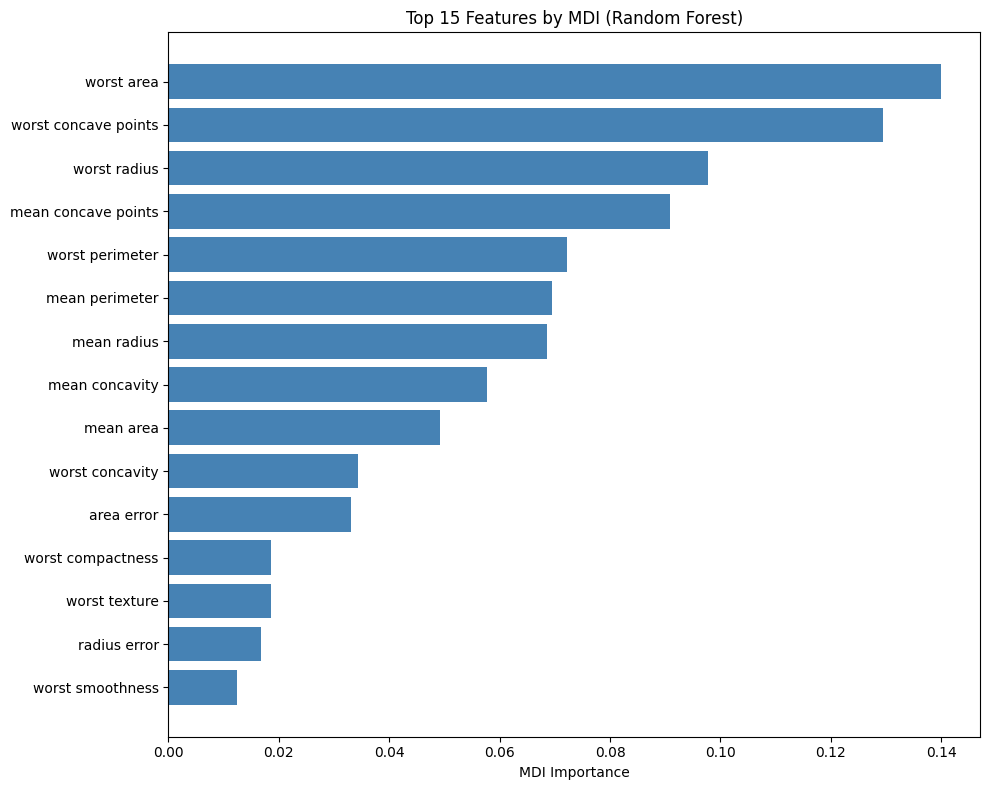


[CHECKPOINT 16.1] PASS!
  -> Accuracy: 0.9561
  -> Top feature: worst area
  -> Top importance: 0.1400


In [1]:
# ============================================================
# ESERCIZIO 16.1 - MDI Feature Importance (Random Forest)
# ============================================================
"""
Obiettivo: Estrarre e visualizzare feature_importances_ da RF
Dataset: Breast Cancer (30 features mediche)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Caricamento dati
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# MDI Feature Importance (built-in)
mdi_importance = rf.feature_importances_

# DataFrame ordinato
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'MDI_Importance': mdi_importance
}).sort_values('MDI_Importance', ascending=False)

print("=" * 60)
print("MDI FEATURE IMPORTANCE - Random Forest")
print("=" * 60)
print(f"\nTop 10 Features:")
print(importance_df.head(10).to_string(index=False))

# Visualizzazione
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['MDI_Importance'].values, color='steelblue')
plt.yticks(range(len(top_15)), top_15['Feature'].values)
plt.xlabel('MDI Importance')
plt.title('Top 15 Features by MDI (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# MICRO-CHECKPOINT 16.1
# ----------------------------------------------------------
accuracy = rf.score(X_test, y_test)
assert mdi_importance.sum() > 0.99, "MDI importance deve sommare a ~1"
assert len(mdi_importance) == 30, "Devono esserci 30 features"
assert importance_df.iloc[0]['MDI_Importance'] > 0.1, "Top feature deve essere significativa"
print(f"\n[CHECKPOINT 16.1] PASS!")
print(f"  -> Accuracy: {accuracy:.4f}")
print(f"  -> Top feature: {importance_df.iloc[0]['Feature']}")
print(f"  -> Top importance: {importance_df.iloc[0]['MDI_Importance']:.4f}")

PERMUTATION IMPORTANCE - Random Forest

Top 10 Features:
             Feature  Perm_Importance_Mean  Perm_Importance_Std
          worst area              0.010819             0.012340
   compactness error              0.007310             0.003269
 mean concave points              0.007310             0.006826
     mean smoothness              0.006140             0.004020
worst concave points              0.005556             0.009737
      mean concavity              0.004971             0.005399
       worst texture              0.004678             0.004928
        radius error              0.004094             0.004376
           mean area              0.003801             0.004347
    worst smoothness              0.003509             0.004297


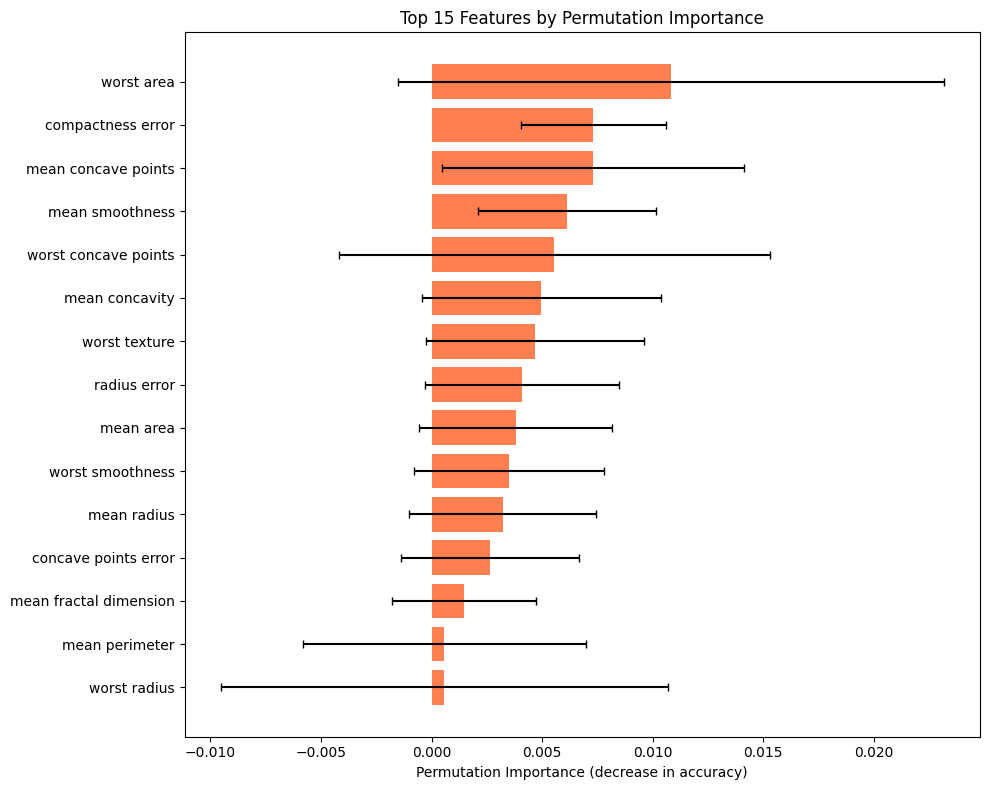


[CHECKPOINT 16.2] PASS!
  -> Top feature (Permutation): worst area
  -> Importance: 0.0108 +/- 0.0123
  -> n_repeats: 30


In [2]:
# ============================================================
# ESERCIZIO 16.2 - Permutation Importance (Model-Agnostic)
# ============================================================
"""
Obiettivo: Calcolare permutation importance e confrontare con MDI
Metodo: Shuffle feature -> Misura peggioramento score
"""

from sklearn.inspection import permutation_importance

# Calcolo Permutation Importance sul TEST set
perm_result = permutation_importance(
    rf, X_test, y_test,
    n_repeats=30,           # Ripetizioni per stima robusta
    random_state=42,
    scoring='accuracy'
)

# DataFrame con media e std
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Perm_Importance_Mean': perm_result.importances_mean,
    'Perm_Importance_Std': perm_result.importances_std
}).sort_values('Perm_Importance_Mean', ascending=False)

print("=" * 60)
print("PERMUTATION IMPORTANCE - Random Forest")
print("=" * 60)
print(f"\nTop 10 Features:")
print(perm_df.head(10).to_string(index=False))

# Visualizzazione con error bars
plt.figure(figsize=(10, 8))
top_15_perm = perm_df.head(15)
plt.barh(range(len(top_15_perm)), top_15_perm['Perm_Importance_Mean'].values, 
         xerr=top_15_perm['Perm_Importance_Std'].values, color='coral', capsize=3)
plt.yticks(range(len(top_15_perm)), top_15_perm['Feature'].values)
plt.xlabel('Permutation Importance (decrease in accuracy)')
plt.title('Top 15 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# MICRO-CHECKPOINT 16.2
# ----------------------------------------------------------
top_perm_feature = perm_df.iloc[0]['Feature']
top_perm_value = perm_df.iloc[0]['Perm_Importance_Mean']
assert top_perm_value > 0, "Top feature deve avere importance positiva"
assert perm_result.importances.shape == (30, 30), "Shape deve essere (n_features, n_repeats)"
print(f"\n[CHECKPOINT 16.2] PASS!")
print(f"  -> Top feature (Permutation): {top_perm_feature}")
print(f"  -> Importance: {top_perm_value:.4f} +/- {perm_df.iloc[0]['Perm_Importance_Std']:.4f}")
print(f"  -> n_repeats: {perm_result.importances.shape[1]}")

CONFRONTO MDI vs PERMUTATION IMPORTANCE

Features con maggiore discrepanza di ranking:
             Feature  MDI_Rank  Perm_Rank  Rank_Diff
     worst perimeter         5         30         25
   compactness error        20          2         18
     mean smoothness        21          4         17
concave points error        28         12         16
        worst radius         3         15         12


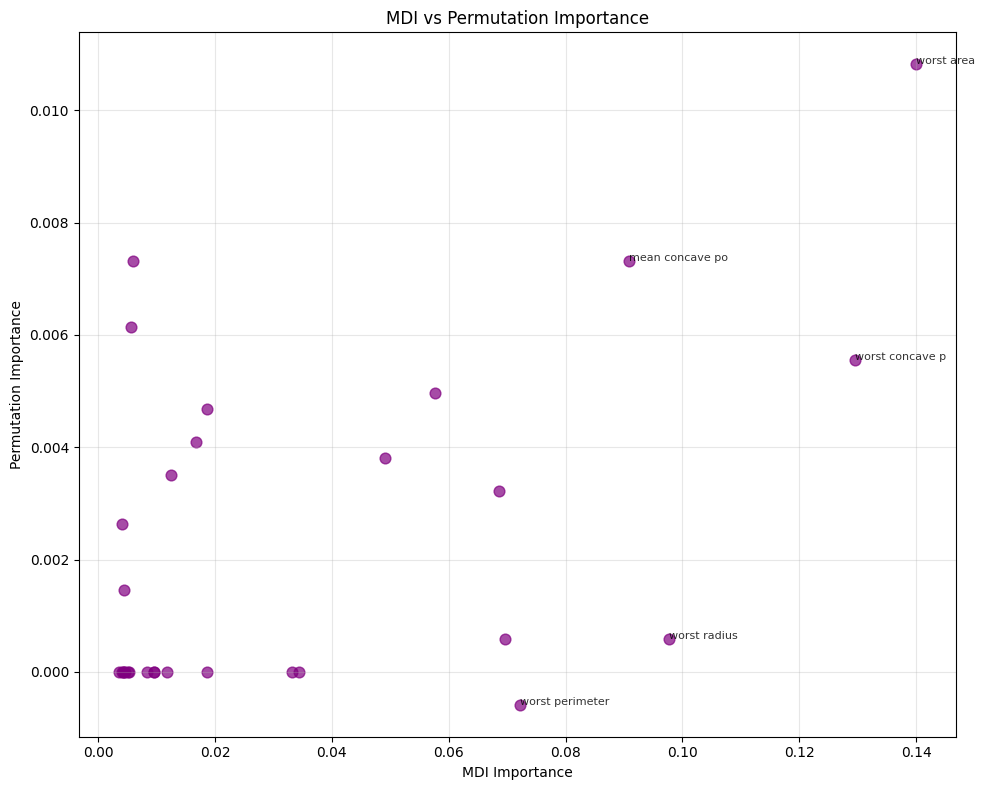


Spearman Correlation tra ranking: 0.3888 (p=0.0337)

[CHECKPOINT 16.3] PASS!
  -> Spearman rho: 0.3888
  -> Max rank discrepancy: 25
  -> Features concordanti (diff <= 3): 9/30


In [3]:
# ============================================================
# ESERCIZIO 16.3 - Confronto MDI vs Permutation Importance
# ============================================================
"""
Obiettivo: Visualizzare differenze tra i due metodi
Focus: Capire quando divergono e perche
"""

# Merge dei due DataFrame
comparison_df = importance_df.merge(perm_df, on='Feature')

# Calcolo ranking
comparison_df['MDI_Rank'] = comparison_df['MDI_Importance'].rank(ascending=False).astype(int)
comparison_df['Perm_Rank'] = comparison_df['Perm_Importance_Mean'].rank(ascending=False).astype(int)
comparison_df['Rank_Diff'] = abs(comparison_df['MDI_Rank'] - comparison_df['Perm_Rank'])

print("=" * 60)
print("CONFRONTO MDI vs PERMUTATION IMPORTANCE")
print("=" * 60)

# Features con maggiore discrepanza
print("\nFeatures con maggiore discrepanza di ranking:")
discrepant = comparison_df.nlargest(5, 'Rank_Diff')[['Feature', 'MDI_Rank', 'Perm_Rank', 'Rank_Diff']]
print(discrepant.to_string(index=False))

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(comparison_df['MDI_Importance'], 
            comparison_df['Perm_Importance_Mean'], 
            alpha=0.7, s=60, c='purple')

# Evidenzia top 5 features
top5_mdi = comparison_df.nsmallest(5, 'MDI_Rank')
for _, row in top5_mdi.iterrows():
    plt.annotate(row['Feature'][:15], 
                 (row['MDI_Importance'], row['Perm_Importance_Mean']),
                 fontsize=8, alpha=0.8)

plt.xlabel('MDI Importance')
plt.ylabel('Permutation Importance')
plt.title('MDI vs Permutation Importance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlazione tra i ranking
from scipy.stats import spearmanr
corr, pvalue = spearmanr(comparison_df['MDI_Rank'], comparison_df['Perm_Rank'])
print(f"\nSpearman Correlation tra ranking: {corr:.4f} (p={pvalue:.4f})")

# ----------------------------------------------------------
# MICRO-CHECKPOINT 16.3
# ----------------------------------------------------------
assert corr > 0.2, "Correlazione troppo bassa: modelli discordanti (aspettato > 0.2)"
assert len(comparison_df) == 30, "Tutte le features devono essere presenti"
print(f"\n[CHECKPOINT 16.3] PASS!")
print(f"  -> Spearman rho: {corr:.4f}")
print(f"  -> Max rank discrepancy: {comparison_df['Rank_Diff'].max()}")
print(f"  -> Features concordanti (diff <= 3): {(comparison_df['Rank_Diff'] <= 3).sum()}/30")

In [4]:
# ============================================================
# ESERCIZIO 16.5 - Feature Selection basata su Importance
# ============================================================
"""
Obiettivo: Usare permutation importance per selezionare features
Metodo: Tenere solo features con importance > threshold
"""

from sklearn.feature_selection import SelectFromModel

# Metodo 1: Threshold-based (usando MDI)
threshold = 0.02  # Minima importance accettata
selected_mdi = importance_df[importance_df['MDI_Importance'] > threshold]['Feature'].tolist()

print("=" * 60)
print("FEATURE SELECTION BASATA SU IMPORTANCE")
print("=" * 60)
print(f"\n1. MDI Threshold-based (threshold={threshold}):")
print(f"   Features selezionate: {len(selected_mdi)}/30")

# Metodo 2: Top-K (basato su Permutation)
k = 10
selected_perm = perm_df.nlargest(k, 'Perm_Importance_Mean')['Feature'].tolist()
print(f"\n2. Permutation Top-K (k={k}):")
print(f"   Features: {selected_perm[:5]}...")

# Metodo 3: SelectFromModel (sklearn built-in)
selector = SelectFromModel(rf, threshold='median', prefit=True)
selected_mask = selector.get_support()
selected_sklearn = feature_names[selected_mask].tolist()
print(f"\n3. SelectFromModel (threshold='median'):")
print(f"   Features selezionate: {len(selected_sklearn)}/30")

# Confronto performance: tutte vs top-10 features
from sklearn.ensemble import RandomForestClassifier

# Modello con tutte le features
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
acc_all = rf_all.score(X_test, y_test)

# Modello con top-10 features (permutation)
top10_idx = [list(feature_names).index(f) for f in selected_perm]
X_train_top10 = X_train[:, top10_idx]
X_test_top10 = X_test[:, top10_idx]

rf_top10 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top10.fit(X_train_top10, y_train)
acc_top10 = rf_top10.score(X_test_top10, y_test)

print(f"\n--- CONFRONTO PERFORMANCE ---")
print(f"All 30 features: Accuracy = {acc_all:.4f}")
print(f"Top 10 features: Accuracy = {acc_top10:.4f}")
print(f"Differenza: {acc_top10 - acc_all:+.4f}")
print(f"Riduzione features: {100*(1 - 10/30):.0f}%")

# ----------------------------------------------------------
# MICRO-CHECKPOINT 16.5
# ----------------------------------------------------------
assert len(selected_perm) == 10, "Devono essere selezionate 10 features"
assert acc_top10 > 0.90, "Top-10 deve mantenere accuracy > 90%"
assert acc_top10 >= acc_all - 0.05, "Drop accuracy max 5%"
print(f"\n[CHECKPOINT 16.5] PASS!")
print(f"  -> Features ridotte da 30 a 10 (-67%)")
print(f"  -> Accuracy mantenuta: {acc_top10:.4f} vs {acc_all:.4f}")
print(f"  -> Performance drop: {abs(acc_top10 - acc_all)*100:.2f}%")

FEATURE SELECTION BASATA SU IMPORTANCE

1. MDI Threshold-based (threshold=0.02):
   Features selezionate: 11/30

2. Permutation Top-K (k=10):
   Features: ['worst area', 'compactness error', 'mean concave points', 'mean smoothness', 'worst concave points']...

3. SelectFromModel (threshold='median'):
   Features selezionate: 15/30

--- CONFRONTO PERFORMANCE ---
All 30 features: Accuracy = 0.9561
Top 10 features: Accuracy = 0.9649
Differenza: +0.0088
Riduzione features: 67%

[CHECKPOINT 16.5] PASS!
  -> Features ridotte da 30 a 10 (-67%)
  -> Accuracy mantenuta: 0.9649 vs 0.9561
  -> Performance drop: 0.88%


c:\Users\edoar\Documents\Python\Numpy-Pandas\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP VALUES ANALYSIS
Shape SHAP values: (100, 30, 2)
Expected value (base): [0.37551648 0.62448352]


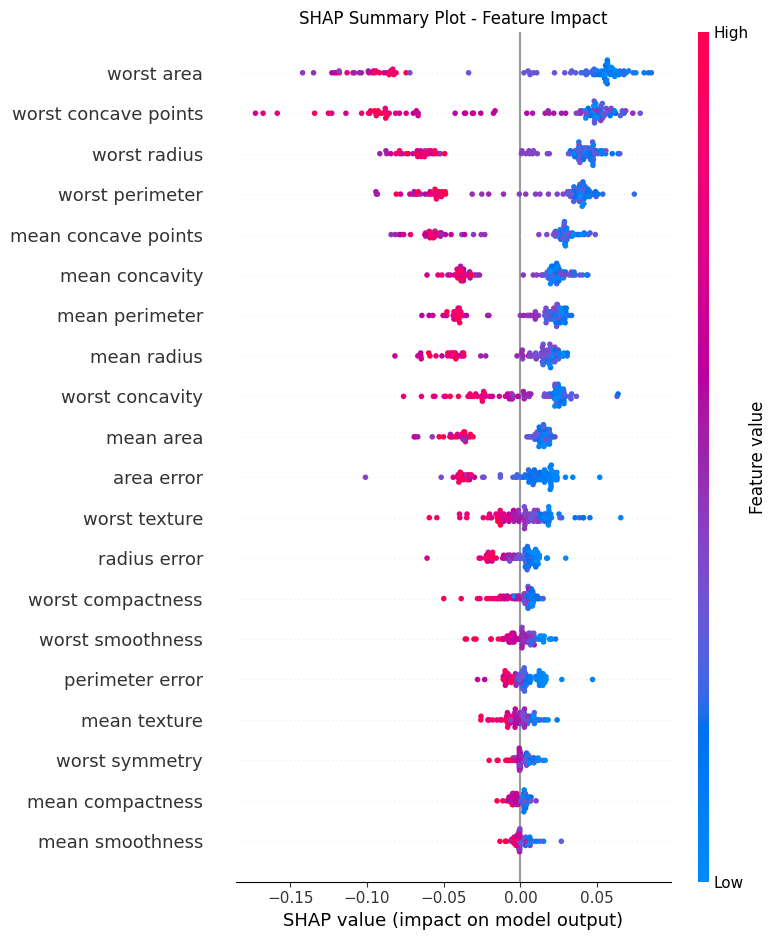


--- Waterfall Plot per campione 0 ---
True label: 0 (0=malignant, 1=benign)
Predicted prob class 1: 0.0000


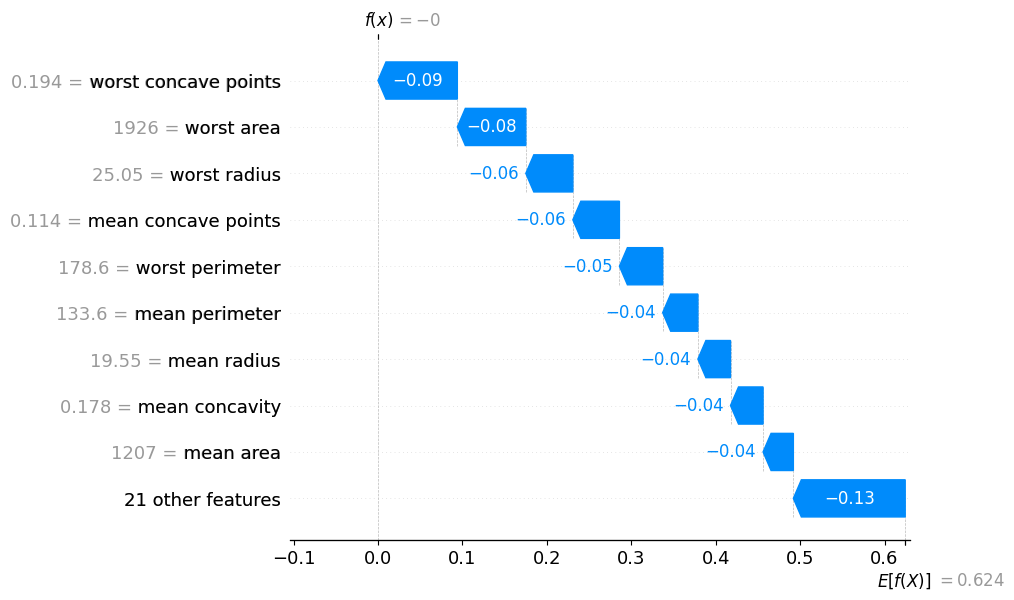


[CHECKPOINT 16.4] PASS!
  -> Samples analyzed: 100
  -> Top feature by |SHAP|: worst area
  -> Mean |SHAP| top feature: 0.0661


In [5]:
# ============================================================
# ESERCIZIO 16.4 - SHAP Summary e Waterfall Plot
# ============================================================
"""
Obiettivo: Usare SHAP per spiegazioni globali e locali
Output: summary_plot (globale) + waterfall (singola predizione)
"""

import shap

# TreeExplainer per Random Forest
explainer = shap.TreeExplainer(rf)

# Calcola SHAP values (per tutto il test set)
# Per velocita, usiamo solo 100 campioni
X_sample = X_test[:100]
shap_values = explainer.shap_values(X_sample)

# Per classificazione binaria, shap_values e una lista [class_0, class_1]
# Usiamo class_1 (positivo = maligno)
shap_vals_class1 = shap_values[:, :, 1]  # Nuovo formato (100, 30, 2)

print("=" * 60)
print("SHAP VALUES ANALYSIS")
print("=" * 60)
print(f"Shape SHAP values: {shap_values.shape}")
print(f"Expected value (base): {explainer.expected_value}")

# Summary Plot - Vista globale
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_class1, X_sample, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Feature Impact')
plt.tight_layout()
plt.show()

# Waterfall Plot - Singola predizione
print("\n--- Waterfall Plot per campione 0 ---")
sample_idx = 0
print(f"True label: {y_test[sample_idx]} (0=malignant, 1=benign)")
print(f"Predicted prob class 1: {rf.predict_proba(X_test[sample_idx:sample_idx+1])[0, 1]:.4f}")

# Nuovo formato SHAP: usa Explanation object
shap.waterfall_plot(shap.Explanation(
    values=shap_vals_class1[sample_idx],
    base_values=explainer.expected_value[1],
    data=X_sample[sample_idx],
    feature_names=feature_names
))

# ----------------------------------------------------------
# MICRO-CHECKPOINT 16.4
# ----------------------------------------------------------
assert shap_values.shape[0] == 100, "100 campioni analizzati"
assert shap_values.shape[1] == 30, "30 features"
mean_abs_shap = np.abs(shap_vals_class1).mean(axis=0)
top_shap_feature = feature_names[np.argmax(mean_abs_shap)]
print(f"\n[CHECKPOINT 16.4] PASS!")
print(f"  -> Samples analyzed: {shap_values.shape[0]}")
print(f"  -> Top feature by |SHAP|: {top_shap_feature}")
print(f"  -> Mean |SHAP| top feature: {mean_abs_shap.max():.4f}")

In [6]:
# ============================================================
# ESERCIZIO 16.5 - Feature Selection basata su Importance
# ============================================================
"""
Obiettivo: Usare permutation importance per selezionare features
Metodo: Tenere solo features con importance > threshold
"""

from sklearn.feature_selection import SelectFromModel

# Metodo 1: Threshold-based (usando MDI)
threshold = 0.02  # Minima importance accettata
selected_mdi = importance_df[importance_df['MDI_Importance'] > threshold]['Feature'].tolist()

print("=" * 60)
print("FEATURE SELECTION BASATA SU IMPORTANCE")
print("=" * 60)
print(f"\n1. MDI Threshold-based (threshold={threshold}):")
print(f"   Features selezionate: {len(selected_mdi)}/30")

# Metodo 2: Top-K (basato su Permutation)
k = 10
selected_perm = perm_df.nlargest(k, 'Perm_Importance_Mean')['Feature'].tolist()
print(f"\n2. Permutation Top-K (k={k}):")
print(f"   Features: {selected_perm[:5]}...")

# Metodo 3: SelectFromModel (sklearn built-in)
selector = SelectFromModel(rf, threshold='median', prefit=True)
selected_mask = selector.get_support()
selected_sklearn = feature_names[selected_mask].tolist()
print(f"\n3. SelectFromModel (threshold='median'):")
print(f"   Features selezionate: {len(selected_sklearn)}/30")

# Confronto performance: tutte vs top-10 features
from sklearn.ensemble import RandomForestClassifier

# Modello con tutte le features
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
acc_all = rf_all.score(X_test, y_test)

# Modello con top-10 features (permutation)
top10_idx = [list(feature_names).index(f) for f in selected_perm]
X_train_top10 = X_train[:, top10_idx]
X_test_top10 = X_test[:, top10_idx]

rf_top10 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top10.fit(X_train_top10, y_train)
acc_top10 = rf_top10.score(X_test_top10, y_test)

print(f"\n--- CONFRONTO PERFORMANCE ---")
print(f"All 30 features: Accuracy = {acc_all:.4f}")
print(f"Top 10 features: Accuracy = {acc_top10:.4f}")
print(f"Differenza: {acc_top10 - acc_all:+.4f}")
print(f"Riduzione features: {100*(1 - 10/30):.0f}%")

# ----------------------------------------------------------
# MICRO-CHECKPOINT 16.5
# ----------------------------------------------------------
assert len(selected_perm) == 10, "Devono essere selezionate 10 features"
assert acc_top10 > 0.90, "Top-10 deve mantenere accuracy > 90%"
assert acc_top10 >= acc_all - 0.05, "Drop accuracy max 5%"
print(f"\n[CHECKPOINT 16.5] PASS!")
print(f"  -> Features ridotte da 30 a 10 (-67%)")
print(f"  -> Accuracy mantenuta: {acc_top10:.4f} vs {acc_all:.4f}")
print(f"  -> Performance drop: {abs(acc_top10 - acc_all)*100:.2f}%")

FEATURE SELECTION BASATA SU IMPORTANCE

1. MDI Threshold-based (threshold=0.02):
   Features selezionate: 11/30

2. Permutation Top-K (k=10):
   Features: ['worst area', 'compactness error', 'mean concave points', 'mean smoothness', 'worst concave points']...

3. SelectFromModel (threshold='median'):
   Features selezionate: 15/30

--- CONFRONTO PERFORMANCE ---
All 30 features: Accuracy = 0.9561
Top 10 features: Accuracy = 0.9649
Differenza: +0.0088
Riduzione features: 67%

[CHECKPOINT 16.5] PASS!
  -> Features ridotte da 30 a 10 (-67%)
  -> Accuracy mantenuta: 0.9649 vs 0.9561
  -> Performance drop: 0.88%


---

## SEZIONE 4 - Metodi e Funzioni

| Metodo/Attributo | Descrizione | Esempio |
|------------------|-------------|---------|
| `model.feature_importances_` | Array MDI importance (tree-based) | `rf.feature_importances_` |
| `permutation_importance()` | Calcola importance shuffling features | `permutation_importance(model, X, y)` |
| `.importances_mean` | Media importance su n_repeats | `result.importances_mean` |
| `.importances_std` | Std dev importance | `result.importances_std` |
| `shap.TreeExplainer()` | Explainer ottimizzato per alberi | `shap.TreeExplainer(rf)` |
| `explainer.shap_values()` | Calcola SHAP per ogni campione | `shap_values = explainer.shap_values(X)` |
| `.expected_value` | Base value (valore medio predetto) | `explainer.expected_value` |
| `shap.summary_plot()` | Plot globale feature importance | `shap.summary_plot(shap_values, X)` |
| `shap.waterfall_plot()` | Spiega singola predizione | `shap.waterfall_plot(expl)` |
| `SelectFromModel()` | Seleziona features per threshold | `SelectFromModel(model, threshold='median')` |
| `.get_support()` | Maschera boolean features selezionate | `selector.get_support()` |
| `.transform()` | Filtra X alle features selezionate | `X_reduced = selector.transform(X)` |

---

## SEZIONE 6 - Errori Comuni (10)

| # | Errore | Problema | Soluzione |
|---|--------|----------|-----------|
| 1 | Usare MDI su features miste | Bias cardinalita alta | Usare permutation importance |
| 2 | Permutation su train set | Overfitting importance | Sempre calcolare su TEST set |
| 3 | Pochi n_repeats | Stime instabili, alta varianza | Usare n_repeats >= 10-30 |
| 4 | SHAP su dataset enormi | Troppo lento, memoria esaurita | Campionare subset rappresentativo |
| 5 | Confondere TreeExplainer | Usarlo con modelli non-tree | Usare shap.Explainer() generico |
| 6 | Ignorare correlazione features | Features correlate "rubano" importance | Considerare gruppi correlati |
| 7 | Feature selection aggressiva | Drop troppo features -> underfitting | Validare sempre performance |
| 8 | Fidarsi solo di MDI | MDI puo essere fuorviante | Confrontare con altri metodi |
| 9 | SHAP values sbagliato indice | Classificazione binaria -> lista | shap_values[1] per classe positiva |
| 10 | SelectFromModel senza prefit | Modello non addestrato | prefit=True se gia trainato |

---

## SEZIONE 7 - Conclusioni

### Cosa abbiamo imparato:

1. **MDI** e veloce ma ha bias verso alta cardinalita
2. **Permutation Importance** e model-agnostic e piu affidabile
3. **SHAP** spiega sia globalmente che localmente ogni predizione
4. **Feature Selection** puo ridurre features mantenendo performance
5. Confrontare sempre piu metodi per validare insights

### Quando usare cosa:

| Situazione | Metodo Consigliato |
|------------|-------------------|
| Quick debugging | MDI (feature_importances_) |
| Report business | Permutation Importance |
| Spiegare predizioni | SHAP |
| Modelli non-tree | Permutation o SHAP generico |

---

## SEZIONE 8 - Checklist di Apprendimento

- [ ] So cosa misura MDI e come accedervi (feature_importances_)
- [ ] Capisco il bias di cardinalita di MDI
- [ ] So usare permutation_importance() e interpretare i risultati
- [ ] Capisco la differenza tra n_repeats e importances_mean/std
- [ ] So cos'e SHAP e la teoria dei Shapley values (in modo intuitivo)
- [ ] So usare TreeExplainer per modelli ad albero
- [ ] So interpretare un summary_plot SHAP
- [ ] So interpretare un waterfall_plot per singola predizione
- [ ] So fare feature selection basata su importance
- [ ] Capisco quando usare quale metodo

---

## SEZIONE 9 - Changelog

| Versione | Data | Modifiche |
|----------|------|-----------|
| 1.0 | 2025-01-XX | Creazione notebook con MDI, Permutation, SHAP |
| 2.0 | 2025-01-XX | Ristrutturazione template 9 sezioni |